In [21]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [25]:
base_url = "https://scrapcraft.mitiendanube.com/productos/"

headers = {
    "User-Agent": "Mozilla/5.0"
}

data = []
links_vistos = set() 

In [ ]:
for page in range(1, 7):
    
    if page == 1:
        url = base_url
    else:
        url = f"{base_url}?page={page}"
    
    print(f"Scrapeando página {page}: {url}")
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")
    
    productos = soup.find_all("div", class_="js-item-product")
    
    for p in productos:
        
        link_tag = p.find("a", href=True)
        if link_tag:
            link = link_tag["href"]
            if link in links_vistos:
                continue
        
            links_vistos.add(link)
        else:
            continue
        
        nombre_tag = p.find("div", class_="js-item-name")
        nombre = nombre_tag.text.strip() if nombre_tag else None
        
        precio_actual_tag = p.find("span", class_="js-price-display")
        
        if precio_actual_tag and precio_actual_tag.get("data-product-price"):
            precio_actual = int(precio_actual_tag["data-product-price"]) / 100
        else:
            precio_actual = None
        

        precio_anterior_tag = p.find("span", class_="js-compare-price-display")
        
        if precio_anterior_tag:
            texto = precio_anterior_tag.text.strip()
            texto = texto.replace("$", "").replace(".", "").strip()
            
            if texto.isdigit():
                precio_anterior = int(texto)
            else:
                precio_anterior = None
        else:
            precio_anterior = None
        
        data.append({
            "pagina": page,
            "nombre": nombre,
            "precio_actual": precio_actual,
            "precio_anterior": precio_anterior,
            "link": link
        })

Scrapeando página 1: https://scrapcraft.mitiendanube.com/productos/
Scrapeando página 2: https://scrapcraft.mitiendanube.com/productos/?page=2
Scrapeando página 3: https://scrapcraft.mitiendanube.com/productos/?page=3
Scrapeando página 4: https://scrapcraft.mitiendanube.com/productos/?page=4
Scrapeando página 5: https://scrapcraft.mitiendanube.com/productos/?page=5
Scrapeando página 6: https://scrapcraft.mitiendanube.com/productos/?page=6


In [27]:
df = pd.DataFrame(data)
df

,pagina,nombre,precio_actual,precio_anterior,link
0,1,Almohadilla de tinta para sello,6900.0,8500,https://scrapcraft.mitiendanube.com/productos/...
1,1,Magic Candy House,10900.0,12000,https://scrapcraft.mitiendanube.com/productos/...
2,1,Vitrales del secreto real,10900.0,16000,https://scrapcraft.mitiendanube.com/productos/...
3,1,Animales de fantasía (Paquete de 3 hojas),10000.0,12000,https://scrapcraft.mitiendanube.com/productos/...
4,1,Confesión Romántica (Stickers),12000.0,14900,https://scrapcraft.mitiendanube.com/productos/...
...,...,...,...,...,...
273,6,Sticker sello de lacre,6900.0,0,https://scrapcraft.mitiendanube.com/productos/...
274,6,Libro vintage (50 hojas),46900.0,50000,https://scrapcraft.mitiendanube.com/productos/...
275,6,Brujita mágica (Washi 2 Metros),14900.0,0,https://scrapcraft.mitiendanube.com/productos/...
276,6,Set de Pluma + Lacre Vintage,70000.0,75000,https://scrapcraft.mitiendanube.com/productos/...


In [ ]:
df_clean = df.copy()

df_clean["descuento_%"] = df_clean.apply(
    lambda x: ((x["precio_anterior"] - x["precio_actual"]) / x["precio_anterior"]) * 100
    if pd.notnull(x["precio_anterior"]) and 
       pd.notnull(x["precio_actual"]) and 
       x["precio_anterior"] != 0
    else 0,
    axis=1
)

df["en_oferta"] = df["descuento_%"] > 0

df

,pagina,nombre,precio_actual,precio_anterior,link,descuento_%,en_oferta
0,1,Almohadilla de tinta para sello,6900.0,8500,https://scrapcraft.mitiendanube.com/productos/...,18.823529,True
1,1,Magic Candy House,10900.0,12000,https://scrapcraft.mitiendanube.com/productos/...,9.166667,True
2,1,Vitrales del secreto real,10900.0,16000,https://scrapcraft.mitiendanube.com/productos/...,31.875000,True
3,1,Animales de fantasía (Paquete de 3 hojas),10000.0,12000,https://scrapcraft.mitiendanube.com/productos/...,16.666667,True
4,1,Confesión Romántica (Stickers),12000.0,14900,https://scrapcraft.mitiendanube.com/productos/...,19.463087,True
...,...,...,...,...,...,...,...
273,6,Sticker sello de lacre,6900.0,0,https://scrapcraft.mitiendanube.com/productos/...,0.000000,False
274,6,Libro vintage (50 hojas),46900.0,50000,https://scrapcraft.mitiendanube.com/productos/...,6.200000,True
275,6,Brujita mágica (Washi 2 Metros),14900.0,0,https://scrapcraft.mitiendanube.com/productos/...,0.000000,False
276,6,Set de Pluma + Lacre Vintage,70000.0,75000,https://scrapcraft.mitiendanube.com/productos/...,6.666667,True


In [31]:
print("Total productos:", len(df))
print("Productos por página:")
print(df["pagina"].value_counts())

Total productos: 278
Productos por página:
pagina
1    48
2    48
3    48
4    48
5    48
6    38
Name: count, dtype: int64


In [34]:
conn = sqlite3.connect("scrapcraft.db")
df.to_sql("productos", conn, if_exists="replace", index=False)
conn.commit()
conn.close()

print("Datos guardados en scrapcraft.db correctamente 🚀")

df.head()

Datos guardados en scrapcraft.db correctamente 🚀


,pagina,nombre,precio_actual,precio_anterior,link,descuento_%
0,1,Almohadilla de tinta para sello,6900.0,8500,https://scrapcraft.mitiendanube.com/productos/...,18.823529
1,1,Magic Candy House,10900.0,12000,https://scrapcraft.mitiendanube.com/productos/...,9.166667
2,1,Vitrales del secreto real,10900.0,16000,https://scrapcraft.mitiendanube.com/productos/...,31.875000
3,1,Animales de fantasía (Paquete de 3 hojas),10000.0,12000,https://scrapcraft.mitiendanube.com/productos/...,16.666667
4,1,Confesión Romántica (Stickers),12000.0,14900,https://scrapcraft.mitiendanube.com/productos/...,19.463087


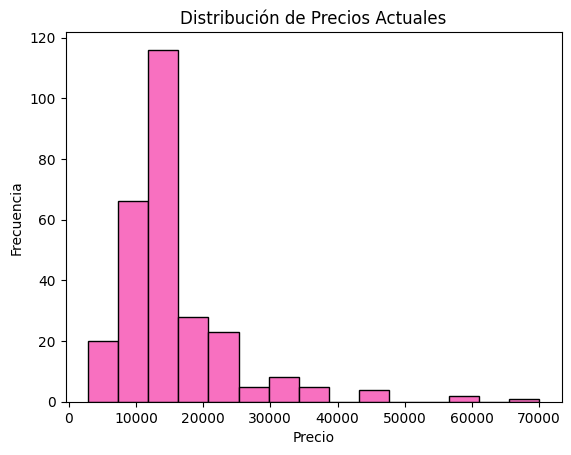

In [62]:
plt.figure()
plt.hist(df_clean["precio_actual"].dropna(), bins=15, color="#F870C0", edgecolor="#000000")
plt.title("Distribución de Precios Actuales")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

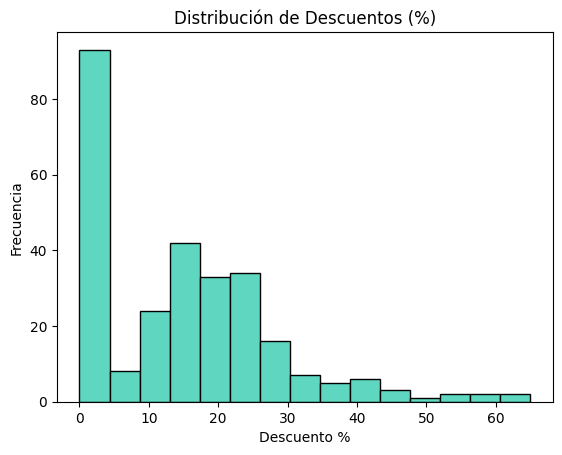

In [58]:
plt.figure()
plt.hist(df_clean["descuento_%"].dropna(), bins=15, color = "#5FD6C0", edgecolor="#000000")
plt.title("Distribución de Descuentos (%)")
plt.xlabel("Descuento %")
plt.ylabel("Frecuencia")
plt.show()

In [37]:
top_10_caros = df_clean.sort_values("precio_actual", ascending=False).head(10)
print("🔝 10 Productos más costosos")
display(top_10_caros[["nombre", "precio_actual", "precio_anterior", "descuento_%"]])

🔝 10 Productos más costosos


,nombre,precio_actual,precio_anterior,descuento_%
276,Set de Pluma + Lacre Vintage,70000.0,75000,6.666667
217,Caja de washis antiguas,60000.0,100000,40.000000
189,Butterfly mail (Kit 140 Pzs),60000.0,80000,25.000000
274,Libro vintage (50 hojas),46900.0,50000,6.200000
271,Libro de frases (40 hojas),45000.0,52000,13.461538
219,Libro de stickers multimaterial,45000.0,0,0.000000
264,Bullet Journal (A5 Punteado),45000.0,52000,13.461538
83,Memories of time book (Libro 20 hojas),36900.0,40000,7.750000
277,Jardín escondido (Libro para colorear 48 hojas),35000.0,40000,12.500000
266,Cuaderno viajero (Color rosa),35000.0,50000,30.000000


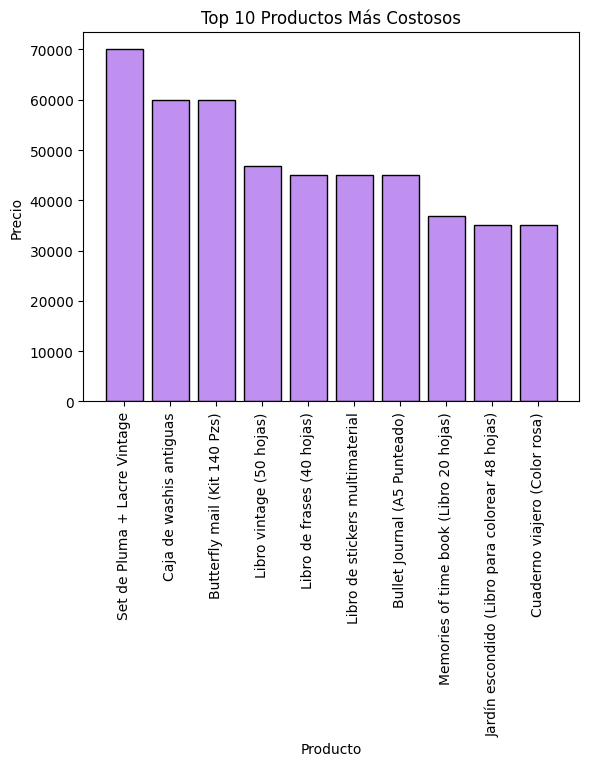

In [49]:
plt.figure()
plt.bar(top_10_caros["nombre"], top_10_caros["precio_actual"], color="#C090F0", edgecolor="#000000")
plt.xticks(rotation=90)
plt.title("Top 10 Productos Más Costosos")
plt.xlabel("Producto")
plt.ylabel("Precio")
plt.show()

In [38]:
top_10_baratos = df_clean.sort_values("precio_actual", ascending=True).head(10)
print("💸 10 Productos más económicos")
display(top_10_baratos[["nombre", "precio_actual", "precio_anterior", "descuento_%"]])

💸 10 Productos más económicos


,nombre,precio_actual,precio_anterior,descuento_%
228,Notas adhesivas animalitos (20 Hojas),2900.0,0,0.000000
20,Estrellas y más estrellas (1 hoja),2900.0,0,0.000000
198,Stickers pasteles (1 hoja),3500.0,0,0.000000
232,Stickers ABC (2 Hojas),3500.0,5000,30.000000
33,Clips gatitos (Unidad),3500.0,5000,30.000000
105,Barra de cera para lacre,4500.0,6500,30.769231
267,Stickers abc (1 hoja),5000.0,0,0.000000
240,Ballenas de ensueño,5500.0,15000,63.333333
21,Papel encaje (20 hojas),5500.0,0,0.000000
133,Frases decorativas (1 Pieza),5500.0,0,0.000000


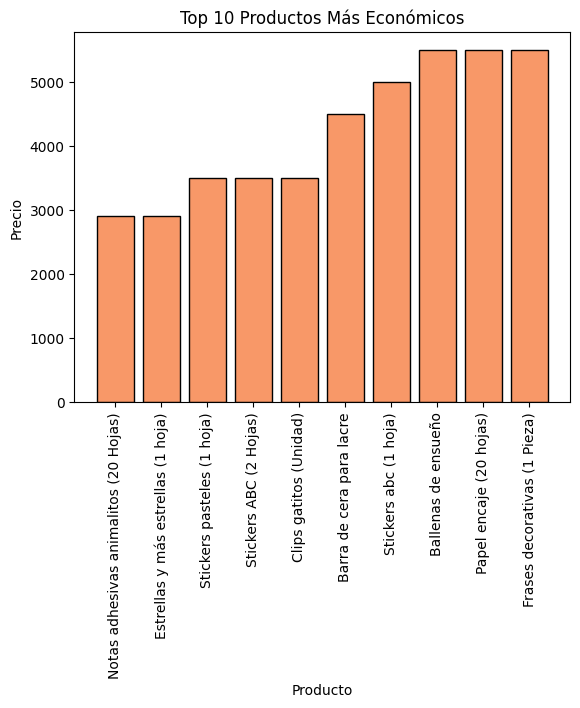

In [52]:
plt.figure()
plt.bar(top_10_baratos["nombre"], top_10_baratos["precio_actual"],color="#F89868", edgecolor="#000000")
plt.xticks(rotation=90)
plt.title("Top 10 Productos Más Económicos")
plt.xlabel("Producto")
plt.ylabel("Precio")
plt.show()

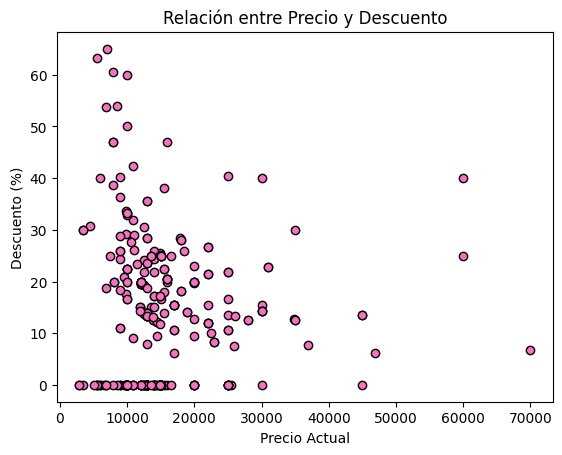

In [53]:
plt.figure()
plt.scatter(df["precio_actual"], df["descuento_%"],color="#F870C0", edgecolors="#000000")
plt.title("Relación entre Precio y Descuento")
plt.xlabel("Precio Actual")
plt.ylabel("Descuento (%)")
plt.show()

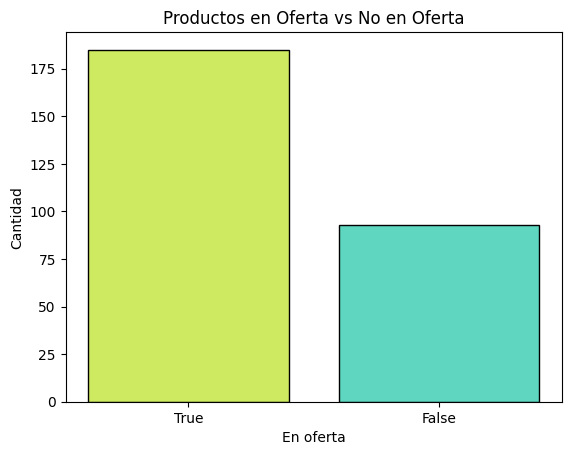

In [56]:
conteo = df["en_oferta"].value_counts()


colores = ["#CEEA60" if x else "#5FD6C0" for x in conteo.index]

plt.figure()
plt.bar(conteo.index.astype(str), conteo.values,color=colores, edgecolor="#000000")
plt.title("Productos en Oferta vs No en Oferta")
plt.xlabel("En oferta")
plt.ylabel("Cantidad")
plt.show()